In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from modules.flight_preprocessor import FlightPreprocessor

### Possible questions:

#### 1. What drives flight delays? (by airline, origin, destination, time of day)
#### 2. Which routes are most/least reliable?
#### 3. Seasonal or daily patterns in cancellations or delays
#### 4. Are there clusters of similar airports/routes?
#### 5. Predict whether a flight will be delayed

In [3]:
df_flights = pd.read_csv("./data/flights.csv", low_memory=False)

# Set the columns to lower case
df_flights.columns = df_flights.columns.str.lower()

In [4]:
df_flights.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,...,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_schedules = df_flights[['scheduled_departure', 'departure_time', 'departure_delay', 'scheduled_arrival', 'arrival_time', 'arrival_delay']]

processor = FlightPreprocessor()
df_schedules = processor.preprocess(df_schedules)

In [6]:
df_schedules.head()

,scheduled_departure,departure_time,departure_delay,scheduled_arrival,arrival_time,arrival_delay
0,2024-01-01 00:05:00,2024-01-01 23:54:00,-11.0,2024-01-02 04:30:00,2024-01-02 04:08:00,-22.0
1,2024-01-01 00:10:00,2024-01-01 00:02:00,-8.0,2024-01-01 07:50:00,2024-01-01 07:41:00,-9.0
2,2024-01-01 00:20:00,2024-01-01 00:18:00,-2.0,2024-01-01 08:06:00,2024-01-01 08:11:00,5.0
3,2024-01-01 00:20:00,2024-01-01 00:15:00,-5.0,2024-01-01 08:05:00,2024-01-01 07:56:00,-9.0
4,2024-01-01 00:25:00,2024-01-01 00:24:00,-1.0,2024-01-01 03:20:00,2024-01-01 02:59:00,-21.0


In [7]:
# Compute delay metrics
df_schedules['dep_delay_min'] = (df_schedules['departure_time'] - df_schedules['scheduled_departure']).dt.total_seconds() / 60
df_schedules['arr_delay_min'] = (df_schedules['arrival_time'] - df_schedules['scheduled_arrival']).dt.total_seconds() / 60

# Additional derived features
df_schedules['day_of_week'] = df_schedules['scheduled_departure'].dt.day_name()
df_schedules['hour'] = df_schedules['scheduled_departure'].dt.hour
df_schedules['is_delayed'] = df_schedules['dep_delay_min'] > 15


In [8]:
df_schedules.head()

,scheduled_departure,departure_time,departure_delay,scheduled_arrival,arrival_time,arrival_delay,dep_delay_min,arr_delay_min,day_of_week,hour,is_delayed
0,2024-01-01 00:05:00,2024-01-01 23:54:00,-11.0,2024-01-02 04:30:00,2024-01-02 04:08:00,-22.0,1429.0,-22.0,Monday,0,True
1,2024-01-01 00:10:00,2024-01-01 00:02:00,-8.0,2024-01-01 07:50:00,2024-01-01 07:41:00,-9.0,-8.0,-9.0,Monday,0,False
2,2024-01-01 00:20:00,2024-01-01 00:18:00,-2.0,2024-01-01 08:06:00,2024-01-01 08:11:00,5.0,-2.0,5.0,Monday,0,False
3,2024-01-01 00:20:00,2024-01-01 00:15:00,-5.0,2024-01-01 08:05:00,2024-01-01 07:56:00,-9.0,-5.0,-9.0,Monday,0,False
4,2024-01-01 00:25:00,2024-01-01 00:24:00,-1.0,2024-01-01 03:20:00,2024-01-01 02:59:00,-21.0,-1.0,-21.0,Monday,0,False


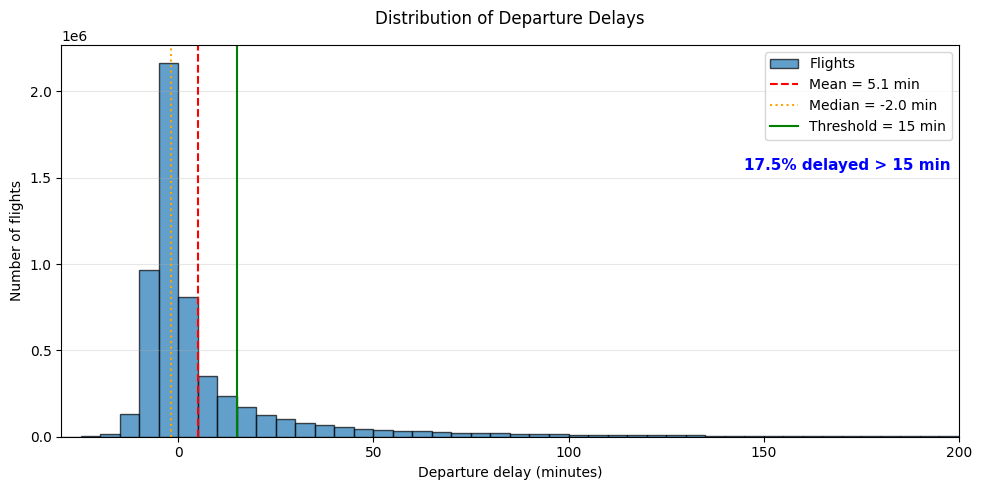

In [41]:
delays = df_schedules['dep_delay_min'].dropna()
threshold = 15  # delay threshold in minutes

plt.figure(figsize=(10, 5))
plt.hist(
    delays,
    bins=np.arange(-30, 301, 5),
    color="#1f77b4",
    alpha=0.7,
    edgecolor="black",
    label="Flights"
)

# Mean and median
mean_delay = delays.mean()
median_delay = delays.median()
plt.axvline(mean_delay, color='red', linestyle='--', linewidth=1.5, label=f"Mean = {mean_delay:.1f} min")
plt.axvline(median_delay, color='orange', linestyle=':', linewidth=1.5, label=f"Median = {median_delay:.1f} min")

# Delay threshold
plt.axvline(threshold, color='green', linestyle='-', linewidth=1.5, label=f"Threshold = {threshold} min")

# Label, title, etc.
plt.xlim(-30, 200)
plt.xlabel('Departure delay (minutes)')
plt.ylabel('Number of flights')
plt.title('Distribution of Departure Delays', pad=15)

# % of delayed flights
delayed_pct = (delays > threshold).mean() * 100
plt.text(
    145, plt.ylim()[1] * 0.68,
    f"{delayed_pct:.1f}% delayed > {threshold} min",
    color="blue", fontsize=11, fontweight="bold"
)

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

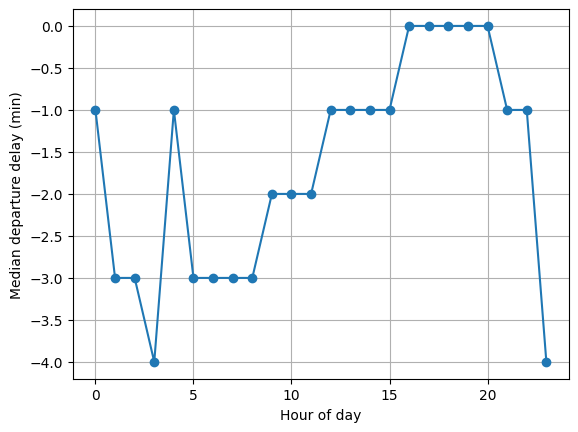

In [42]:
hourly = df_schedules.groupby('hour')['dep_delay_min'].median().reset_index()
plt.plot(hourly['hour'], hourly['dep_delay_min'], marker='o')
plt.xlabel('Hour of day')
plt.ylabel('Median departure delay (min)')
plt.grid(True)
plt.show()